# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
import numpy as np
import cv2
from os import makedirs, listdir
from os.path import join
import shutil
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
from tqdm import tqdm
import tensorflow as tf
from tensorflow.contrib.layers import flatten
np.random.seed(0)
%matplotlib inline

In [2]:
# create a mapping from class index to class name

In [3]:
ind_to_name = {}

In [4]:
reader = csv.reader(open('signnames.csv', 'r'), delimiter=',')
for x in reader:
    index, name = x
    try:
        ind_to_name[int(index)] = name
    except:
        continue

In [5]:
ind_to_name.values()

dict_values(['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric to

In [100]:
# Load pickled data

training_file = '../data/train.p'
validation_file = '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [53]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.
?
**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [8]:
_coords_train = train['coords']
_coords_valid = valid['coords']
_coords_test = test['coords']

sizes_train = train['sizes']
sizes_valid = valid['sizes']
sizes_test = test['sizes']

In [9]:
def get_normalized_coordinates(coords, sizes):
    coords = coords.astype(np.float)
    norm_coords = np.zeros_like(coords)
    norm_coords[:, 0] = coords[:, 0] / sizes[:, 0]
    norm_coords[:, 1] = coords[:, 1] / sizes[:, 1]
    norm_coords[:, 2] = coords[:, 2] / sizes[:, 0]
    norm_coords[:, 3] = coords[:, 3] / sizes[:, 1]
    return norm_coords

In [10]:
coords_train = get_normalized_coordinates(_coords_train, sizes_train)
coords_valid = get_normalized_coordinates(_coords_valid, sizes_valid)
coords_test = get_normalized_coordinates(_coords_test, sizes_test)

In [11]:
np.max(coords_train)

0.98245614035087714

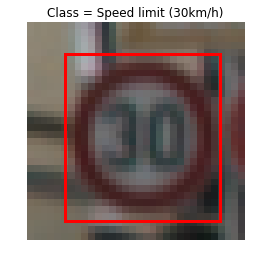

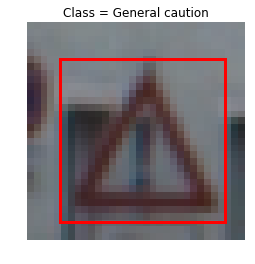

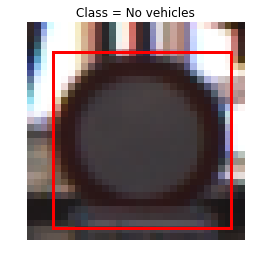

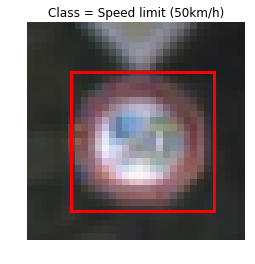

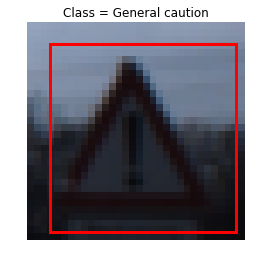

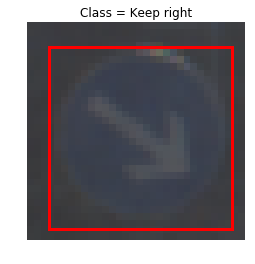

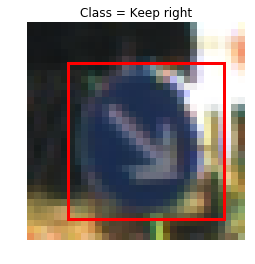

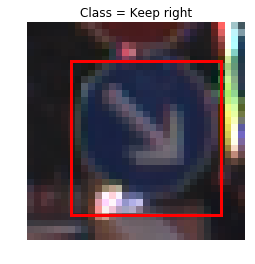

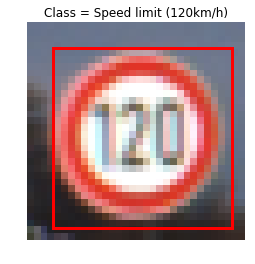

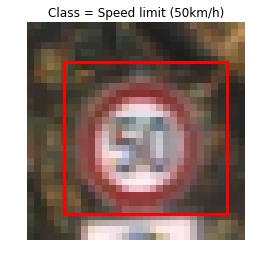

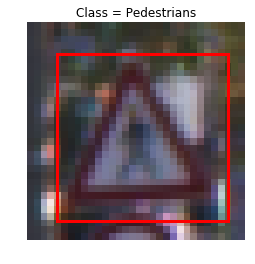

In [12]:
# visualize a few images and the examples
indices = list(np.random.choice(n_train, 10)) + [10350]
for i in indices:
    image = X_train[i]
    label = y_train[i]
    coords = coords_train[i]
    ht, wt = image.shape[:2]
    coords[0] *= wt
    coords[1] *= ht
    coords[2] *= wt
    coords[3] *= ht
    
    x1, y1, x2, y2 = coords
    w = x2 - x1 + 1
    h = y2 - y1 + 1
    
    f, ax = plt.subplots(1, 1)
    ax.imshow(image)
    rect = patches.Rectangle((x1, y1), w, h, linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.set_title('Class = {}'.format(ind_to_name[label]))
    plt.axis('off')
    plt.show()

In [13]:
np.where(y_train == 27)

(array([10350, 10351, 10352, 10353, 10354, 10355, 10356, 10357, 10358,
        10359, 10360, 10361, 10362, 10363, 10364, 10365, 10366, 10367,
        10368, 10369, 10370, 10371, 10372, 10373, 10374, 10375, 10376,
        10377, 10378, 10379, 10380, 10381, 10382, 10383, 10384, 10385,
        10386, 10387, 10388, 10389, 10390, 10391, 10392, 10393, 10394,
        10395, 10396, 10397, 10398, 10399, 10400, 10401, 10402, 10403,
        10404, 10405, 10406, 10407, 10408, 10409, 10410, 10411, 10412,
        10413, 10414, 10415, 10416, 10417, 10418, 10419, 10420, 10421,
        10422, 10423, 10424, 10425, 10426, 10427, 10428, 10429, 10430,
        10431, 10432, 10433, 10434, 10435, 10436, 10437, 10438, 10439,
        10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448,
        10449, 10450, 10451, 10452, 10453, 10454, 10455, 10456, 10457,
        10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466,
        10467, 10468, 10469, 10470, 10471, 10472, 10473, 10474, 10475,
      

In [48]:
# folder to save visualization outputs
viz_save = 'visualization'
makedirs(viz_save, exist_ok=True)

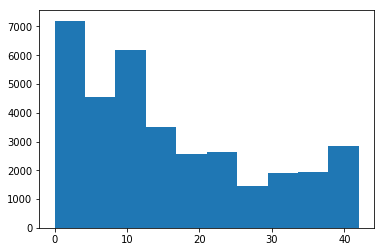

In [50]:
# distribution of classes

# train
plt.hist(y_train)
plt.savefig('visualization/hist_train.png', bbox_inches='tight')
plt.show()

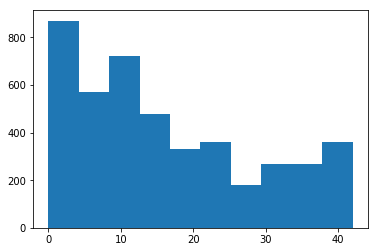

In [51]:
# val
plt.hist(y_valid)
plt.savefig('visualization/hist_valid.png', bbox_inches='tight')
plt.show()

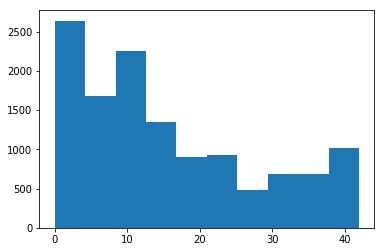

In [52]:
# test
plt.hist(y_test)
plt.savefig('visualization/hist_test.png', bbox_inches='tight')
plt.show()

The data distribution matches in all the 3 sets

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [17]:
# Preprocess the data 
# (X - Mean) / (standard Deviation)
def normalize(X, y, mean, std):
    orig_shape = X.shape
    X = X.reshape((-1, 3))
    X = (X - mean) / std
    X = X.reshape(orig_shape)
    
    X, y = shuffle(X, y)
    return X, y

In [58]:
mean = X_train.reshape((-1, 3)).mean(axis=0)
std = X_train.reshape((-1, 3)).std(axis=0)

In [101]:
X_train_copy = X_train.copy()

In [102]:
X_train, y_train = normalize(X_train, y_train, mean, std)

In [103]:
# use the same mean and standard deviation as that of the train data
# as we don't have these values during inference
X_valid, y_valid = normalize(X_valid, y_valid, mean, std)

In [104]:
# use the same mean and standard deviation as that of the train data
# as we don't have these values during inference
X_test, y_test = normalize(X_test, y_test, mean, std)

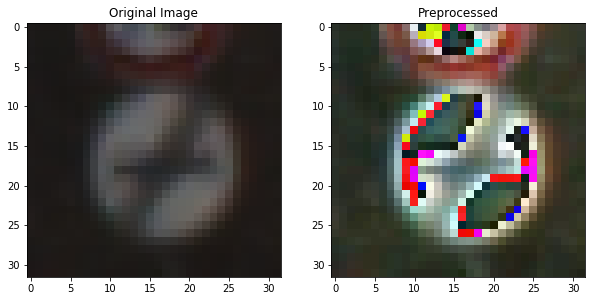

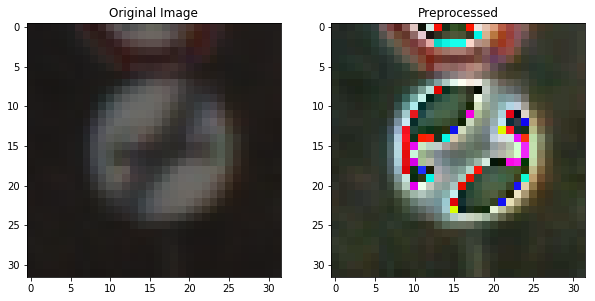

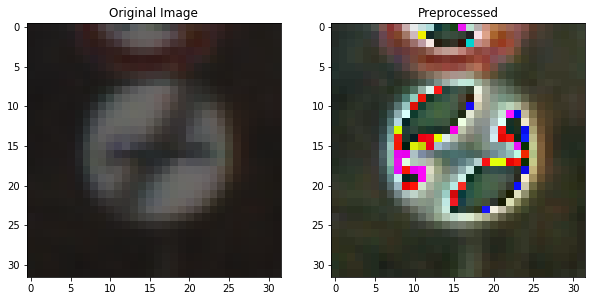

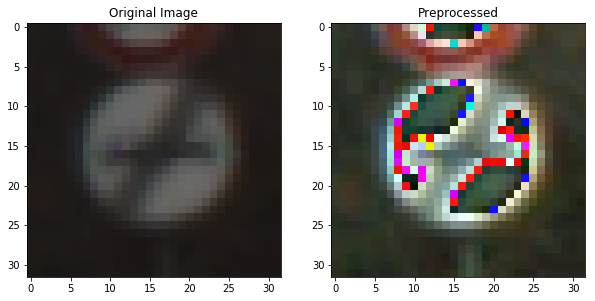

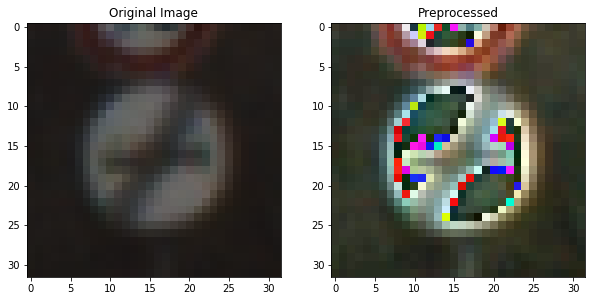

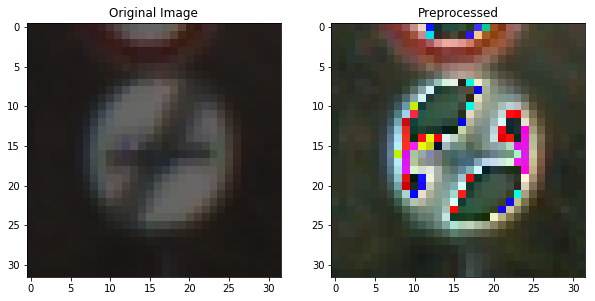

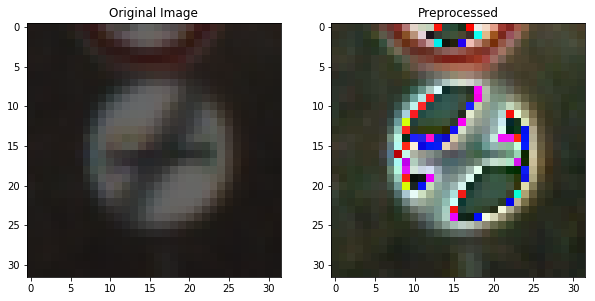

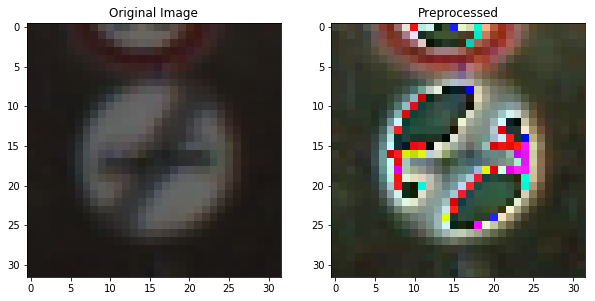

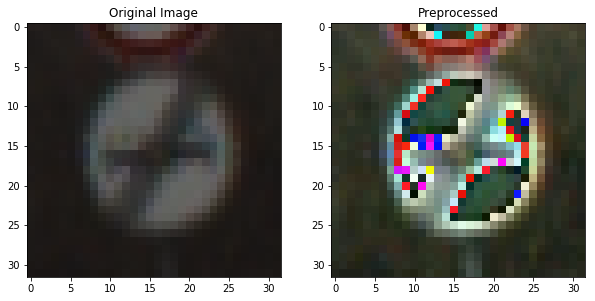

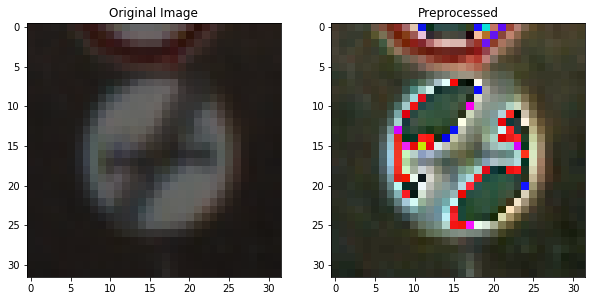

In [95]:
# check randomized examples
for i in range(10):
#     label = y_train[i]
#     print(ind_to_name[label])  
    X = X_train_copy[i]
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X)
    ax[0].set_title('Original Image')
    
    X_ = X.reshape((-1, 3))
    X_ = (X_ - mean) / std
    X_ = X_.reshape(X.shape)
    
    X_ = (X_ * 255).astype(np.uint8)
    ax[1].imshow(X_)
    ax[1].set_title('Preprocessed')
    plt.savefig('visualization/preprocess_{}.png'.format(i+1), bbox_inches='tight')
    plt.show()
#     break

### Model Architecture

I have defined a custom architecture, `MiniVGG`, inspired from `VGGNet` to solve this task. 

In [22]:
# convolution operation
def conv2d(x, in_channels, out_channels, name, kernel_size=3):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    conv_W = tf.Variable(tf.truncated_normal(shape=(kernel_size, kernel_size, in_channels, out_channels), 
                                             mean=mu, stddev=sigma),
                        name='W_' + name)
    conv_b = tf.Variable(tf.zeros(out_channels), name='b_' + name)
    conv   = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='SAME', name='conv2d_' + name) + conv_b
    return conv

In [23]:
# Block of convolution operations followed by a Max pooling operation
def block(x, in_channels, out_channels, n, index):
    for i in range(n):
        x = conv2d(x, in_channels, out_channels, name='{}_{}'.format(index, i))
        x = tf.nn.relu(x)
        in_channels = out_channels
    
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='maxpool_{}'.format(index))
    return x

In [24]:
# Fully connected layer
def fc_layer(x, in_features, out_features, name, activation=True):
    
    mu = 0
    sigma = 0.1
    
    fc_W = tf.Variable(tf.truncated_normal(shape=(in_features, out_features), mean=mu, stddev=sigma),
                       name='W_' + name)
    fc_b = tf.Variable(tf.zeros(out_features), name='b_' + name)
    fc  = tf.matmul(x, fc_W, name='fc_' + name) + fc_b
    
    if activation:
        fc = tf.nn.relu(fc)
        
    return fc

In [25]:
def MiniVGG(x):    
    """
    MiniVGG architecture: Inspired from VGGNet.
    
    """

    conv1 = block(x, 3, 64, 2, '0')
    conv2 = block(conv1, 64, 128, 2, '1')
    fc0 = flatten(conv2)
    fc1 = fc_layer(fc0, 8192, 1024, '2')
    fc2 = fc_layer(fc1, 1024, 1024, '3')
    logits = fc_layer(fc2, 1024, n_classes, '4', activation=False)
    
    return logits

In [26]:
EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [27]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Training pipeline

In [28]:
# logits = LeNet(x)
logits = MiniVGG(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

### Evaluation pipeline

In [29]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [30]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [31]:
save_folder = 'checkpoints'
makedirs(save_folder, exist_ok=True)

In [32]:
best_val_acc = -np.inf

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        data_iterator = tqdm(range(0, num_examples, BATCH_SIZE))
        for offset in data_iterator:
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        if validation_accuracy > best_val_acc:
            best_val_acc = validation_accuracy
            saver.save(sess, 'checkpoints/vgg')
            
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        if validation_accuracy >= 0.93:
            print('Done')
            break
    
    print("Model saved")
    

Training...



100%|██████████| 272/272 [00:23<00:00, 11.69it/s]


EPOCH 1 ...
Validation Accuracy = 0.687



100%|██████████| 272/272 [00:22<00:00, 12.30it/s]


EPOCH 2 ...
Validation Accuracy = 0.782



100%|██████████| 272/272 [00:22<00:00, 12.10it/s]


EPOCH 3 ...
Validation Accuracy = 0.767



100%|██████████| 272/272 [00:22<00:00, 12.02it/s]


EPOCH 4 ...
Validation Accuracy = 0.815



100%|██████████| 272/272 [00:22<00:00, 12.04it/s]


EPOCH 5 ...
Validation Accuracy = 0.824



100%|██████████| 272/272 [00:22<00:00, 12.01it/s]


EPOCH 6 ...
Validation Accuracy = 0.828



100%|██████████| 272/272 [00:22<00:00, 12.10it/s]


EPOCH 7 ...
Validation Accuracy = 0.816



100%|██████████| 272/272 [00:22<00:00, 12.12it/s]


EPOCH 8 ...
Validation Accuracy = 0.846



100%|██████████| 272/272 [00:22<00:00, 12.13it/s]


EPOCH 9 ...
Validation Accuracy = 0.858



100%|██████████| 272/272 [00:22<00:00, 12.13it/s]


EPOCH 10 ...
Validation Accuracy = 0.863



100%|██████████| 272/272 [00:22<00:00, 12.14it/s]


EPOCH 11 ...
Validation Accuracy = 0.885



100%|██████████| 272/272 [00:22<00:00, 12.14it/s]


EPOCH 12 ...
Validation Accuracy = 0.890



100%|██████████| 272/272 [00:22<00:00, 12.11it/s]


EPOCH 13 ...
Validation Accuracy = 0.888



100%|██████████| 272/272 [00:22<00:00, 12.02it/s]


EPOCH 14 ...
Validation Accuracy = 0.904



100%|██████████| 272/272 [00:22<00:00, 12.01it/s]


EPOCH 15 ...
Validation Accuracy = 0.884



100%|██████████| 272/272 [00:22<00:00, 12.03it/s]


EPOCH 16 ...
Validation Accuracy = 0.897



100%|██████████| 272/272 [00:22<00:00, 11.99it/s]


EPOCH 17 ...
Validation Accuracy = 0.892



100%|██████████| 272/272 [00:22<00:00, 12.00it/s]


EPOCH 18 ...
Validation Accuracy = 0.910



100%|██████████| 272/272 [00:22<00:00, 12.01it/s]


EPOCH 19 ...
Validation Accuracy = 0.923



100%|██████████| 272/272 [00:22<00:00, 12.01it/s]


EPOCH 20 ...
Validation Accuracy = 0.918



100%|██████████| 272/272 [00:22<00:00, 12.01it/s]


EPOCH 21 ...
Validation Accuracy = 0.929



100%|██████████| 272/272 [00:22<00:00, 12.01it/s]


EPOCH 22 ...
Validation Accuracy = 0.877



100%|██████████| 272/272 [00:22<00:00, 12.02it/s]


EPOCH 23 ...
Validation Accuracy = 0.929



100%|██████████| 272/272 [00:22<00:00, 12.00it/s]


EPOCH 24 ...
Validation Accuracy = 0.939

Done
Model saved


In [107]:
### Check the validation accuracy: greater than 93% 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    train_accuracy = evaluate(X_train, y_train)
    print("Final train accuracy = {:.3f}".format(train_accuracy))

INFO:tensorflow:Restoring parameters from checkpoints/vgg
Final train accuracy = 0.999


In [106]:
### Check the validation accuracy: greater than 93% 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    validation_accuracy = evaluate(X_valid, y_valid)
    print("Final validation accuracy = {:.3f}".format(validation_accuracy))

INFO:tensorflow:Restoring parameters from checkpoints/vgg
Final validation accuracy = 0.939


In [105]:
### Check the accuracy on the pickled test dataset
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy (pickled dataset) = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from checkpoints/vgg
Test Accuracy (pickled dataset) = 0.933


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [112]:
image_dir = '../data/test/'
image_names = sorted(listdir(image_dir))

In [113]:
image_names

['1.png', '2.png', '3.jpg', '4.png', '5.jpg']

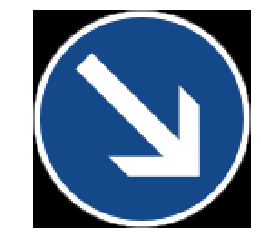

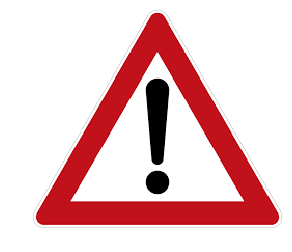

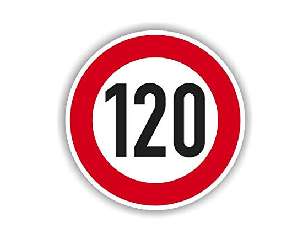

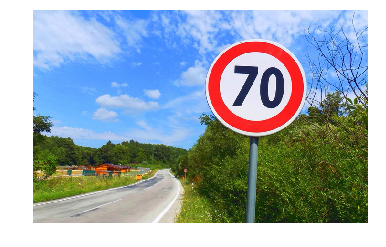

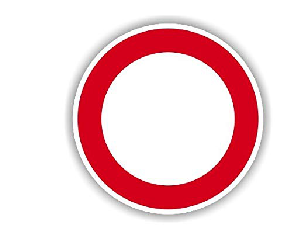

In [114]:
images = []
for image_name in image_names:
    im = cv2.cvtColor(cv2.imread(join(image_dir, image_name)), cv2.COLOR_BGR2RGB)
    images.append(im)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

### Predict the Sign Type for Each Image

In [115]:
test_labels = [38, 18, 8, 4, 15]

In [116]:
test_images = np.zeros((len(images), 32, 32, 3))

In [117]:
for i, image in enumerate(images):
    im = cv2.resize(image, (32, 32))
    test_images[i] = im

In [118]:
test_images = (test_images - mean) / std

In [119]:
test_labels = np.array(test_labels).astype(np.uint8)

In [120]:
test_images.shape

(5, 32, 32, 3)

### Analyze Performance

In [121]:
### Calculate the accuracy for these 5 new images. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    test_accuracy = evaluate(test_images, test_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from checkpoints/vgg
Test Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [127]:
k = 5

In [128]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    topk_values, topk_indices = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=k), feed_dict={x: test_images})
    
#     print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from checkpoints/vgg


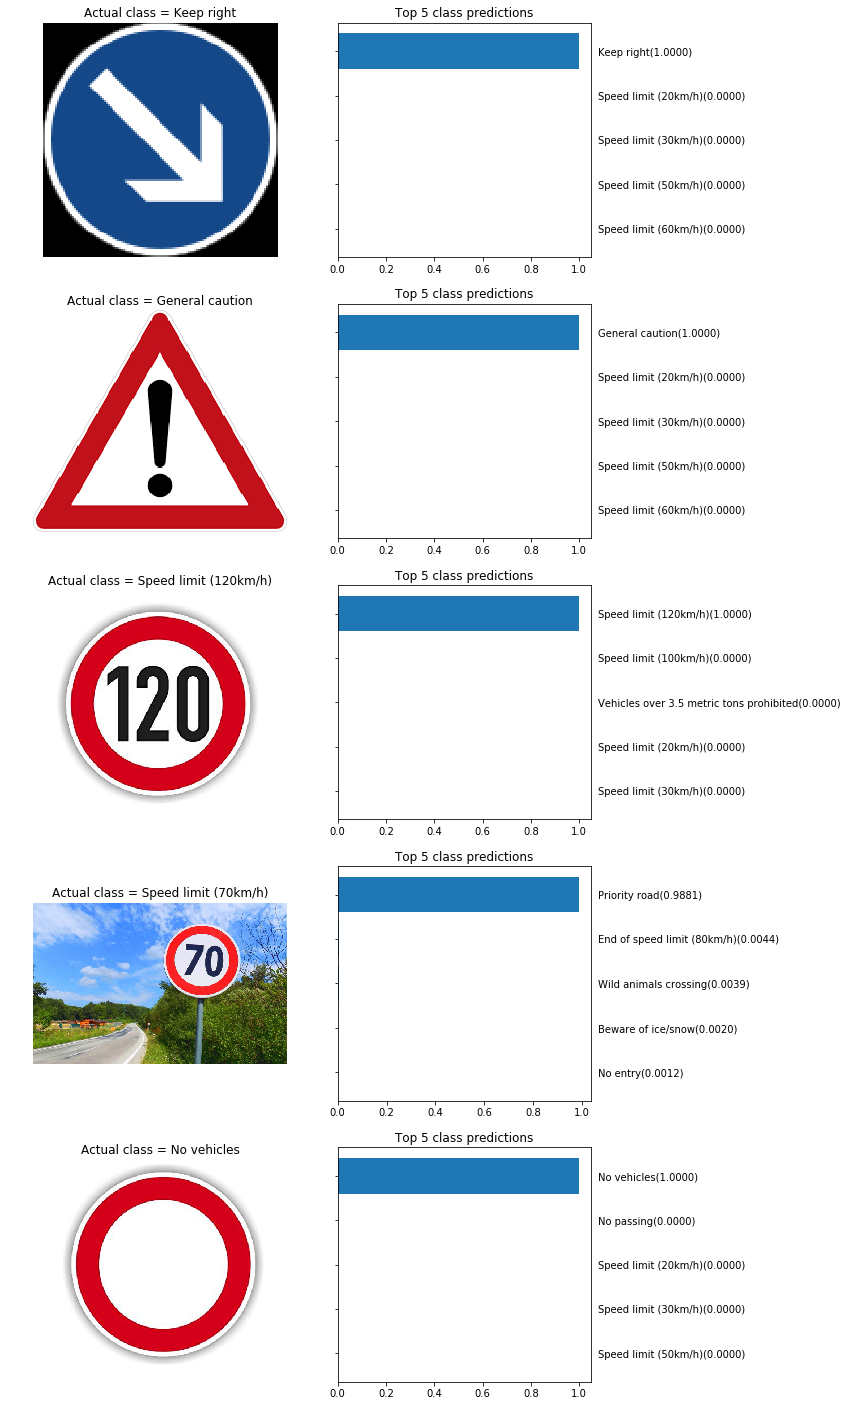

In [133]:
plt.figure(1, figsize=(10, len(test_images) * 5))
for i in range(len(test_images)):
    image = images[i]
    topk_value = topk_values[i]
    topk_index = topk_indices[i]
    topk_classes = [ind_to_name[index] + '({:.4f})'.format(topk_value[i]) for i, index in enumerate(topk_index)]
    
    plt.subplot(len(test_images), 2, (i* 2) +1)
    plt.title('Actual class = {}'.format(ind_to_name[test_labels[i]]))
    plt.imshow(image)
    plt.axis('off')
    
    # plot the bar graph showing the prediction confidences
    plt.subplot(len(test_images), 2, (i* 2) +2)
    plt.title('Top {} class predictions'.format(k))
    plt.barh(np.arange(k), topk_value[::-1])
    plt.yticks(np.arange(k), topk_classes[::-1])
    plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')

plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [134]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(sess, image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
#     print(featuremaps)
    plt.figure(plt_num, figsize=(15,30))
    for featuremap in range(featuremaps):
        plt.subplot(featuremaps/8, 8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.axis('off')
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    

INFO:tensorflow:Restoring parameters from checkpoints/vgg
Image: 1


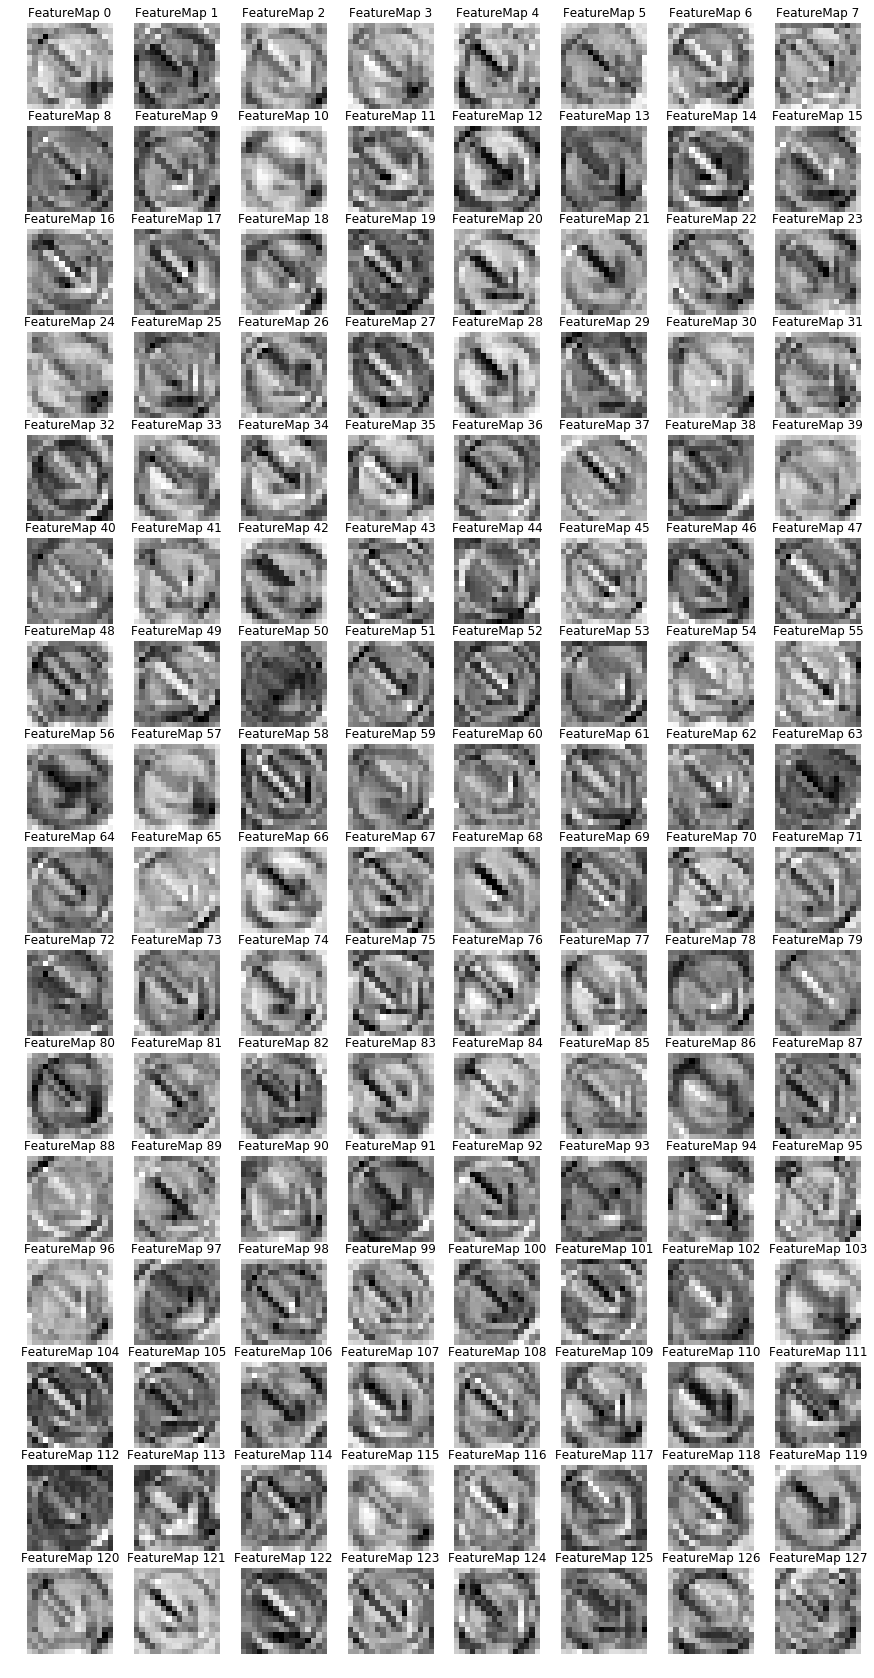

Image: 2


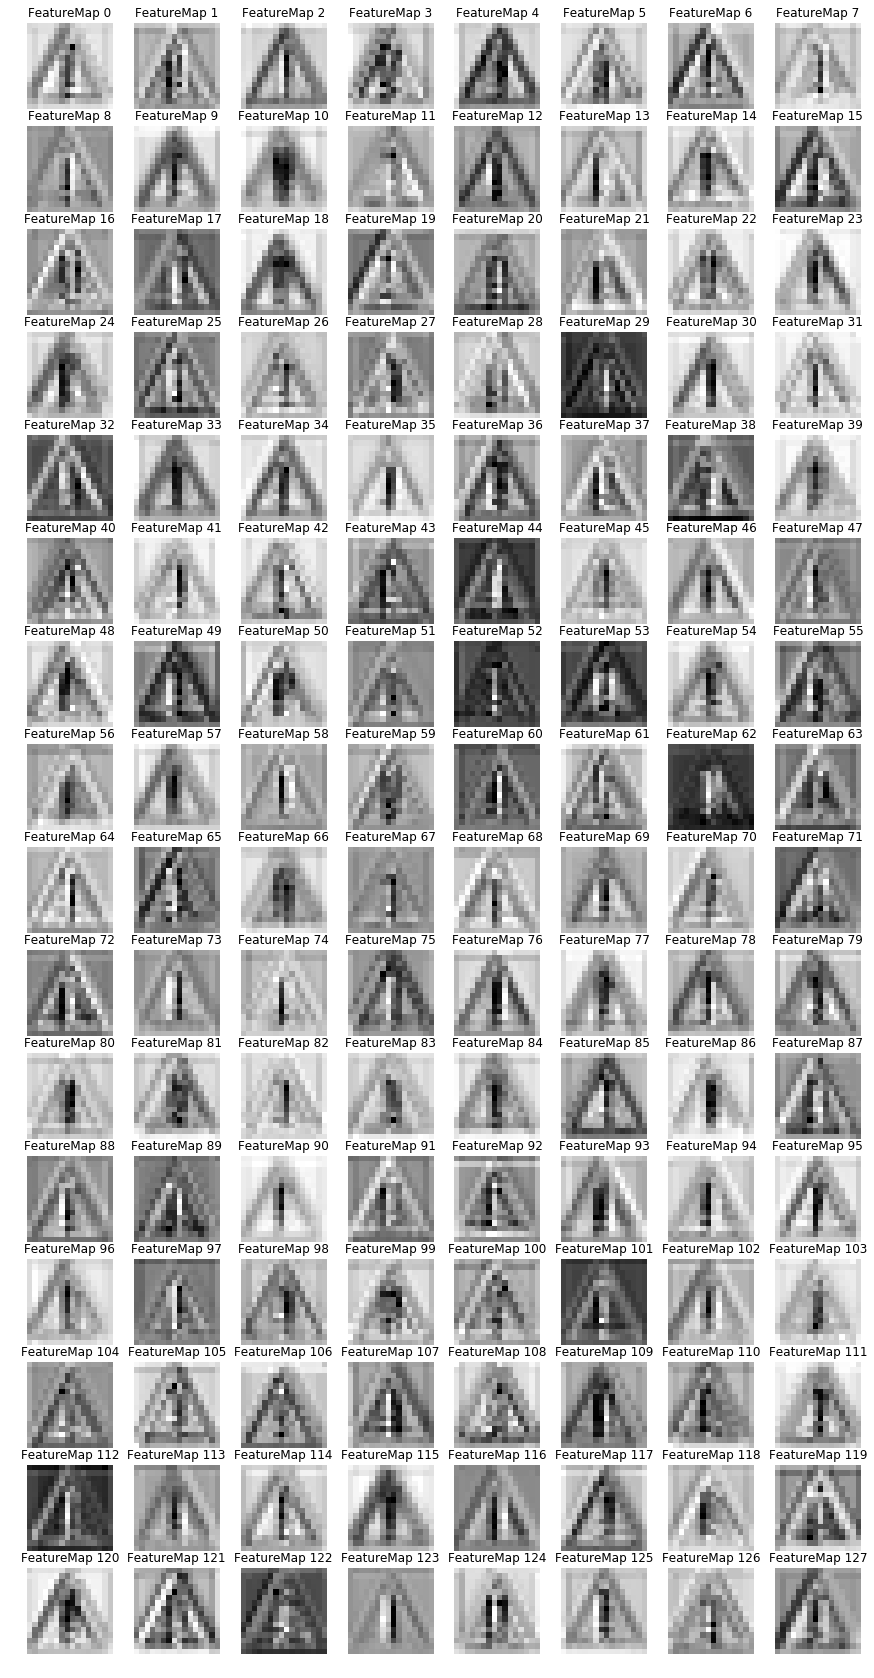

Image: 3


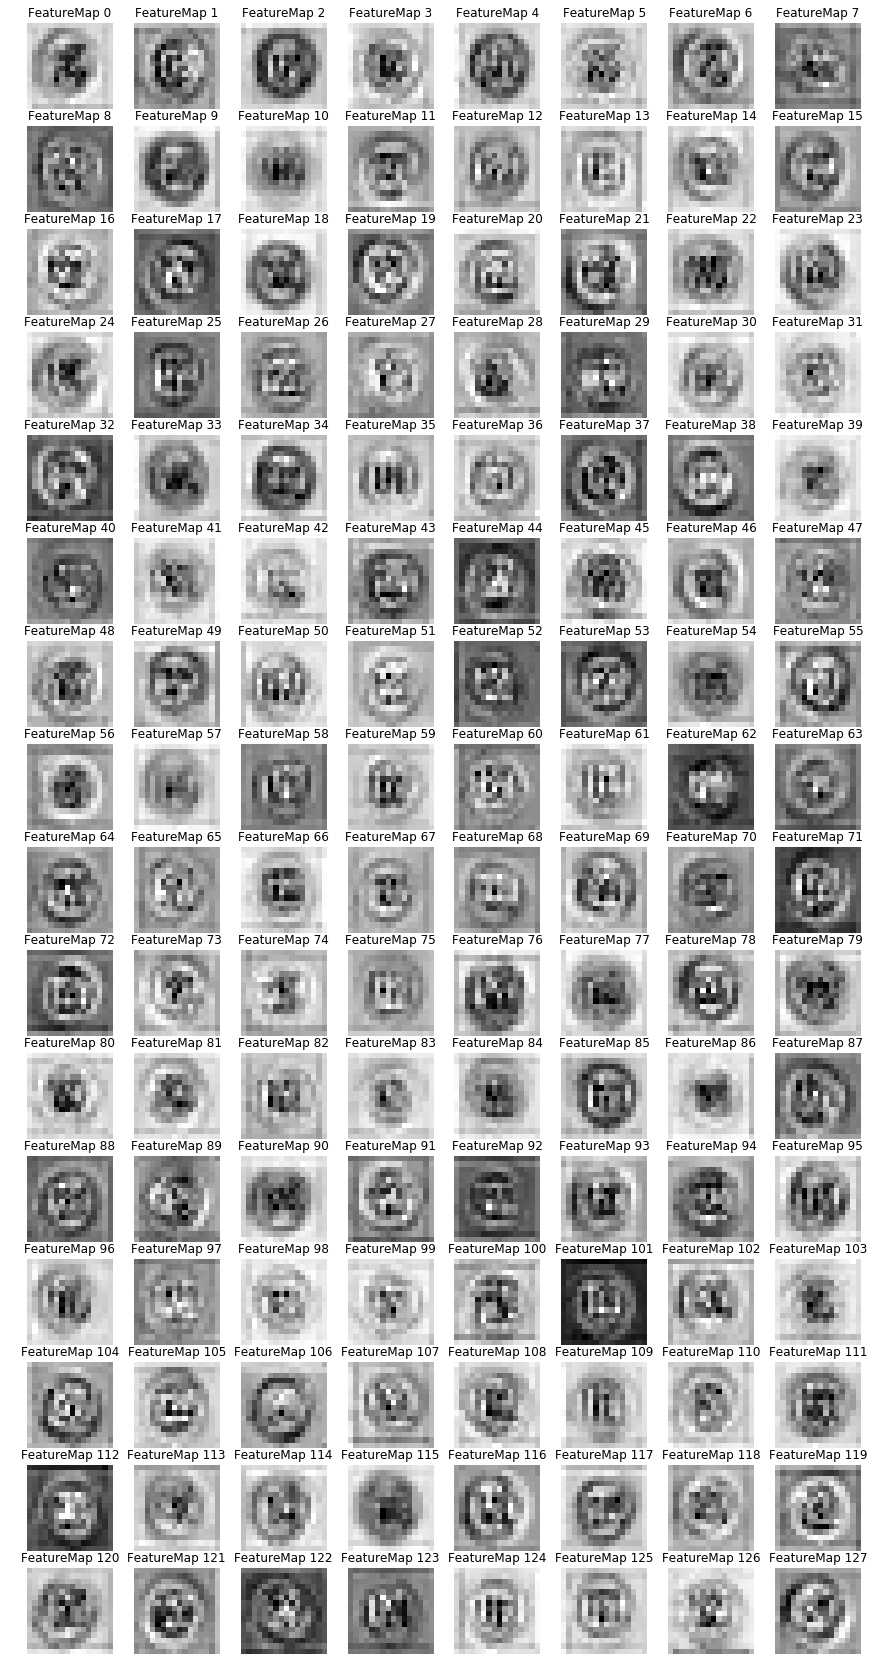

Image: 4


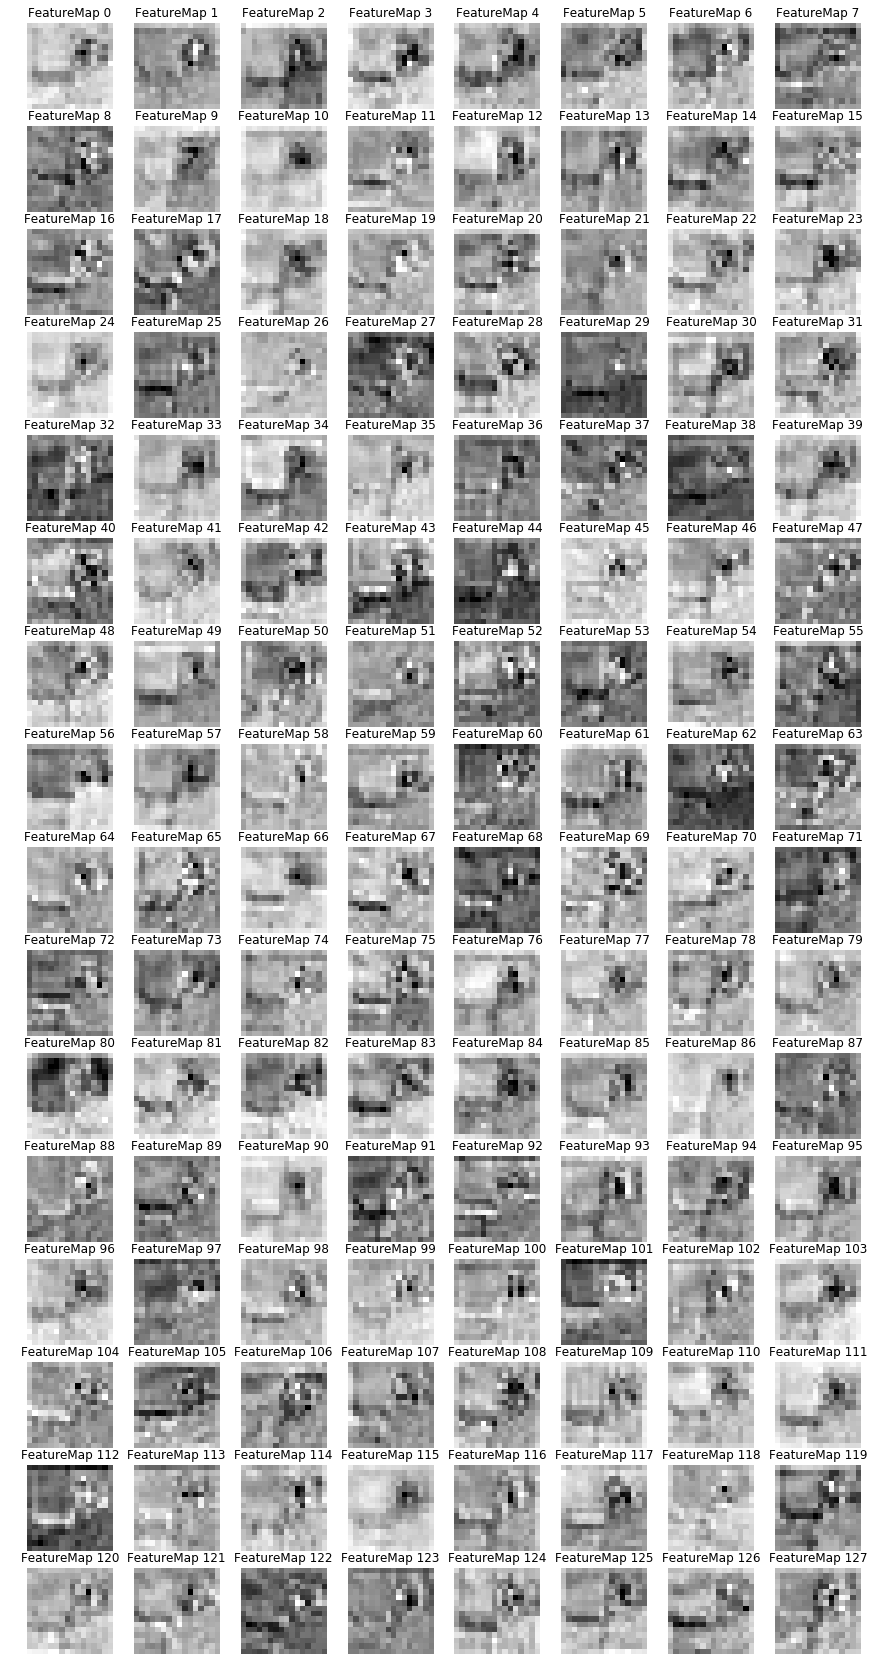

Image: 5


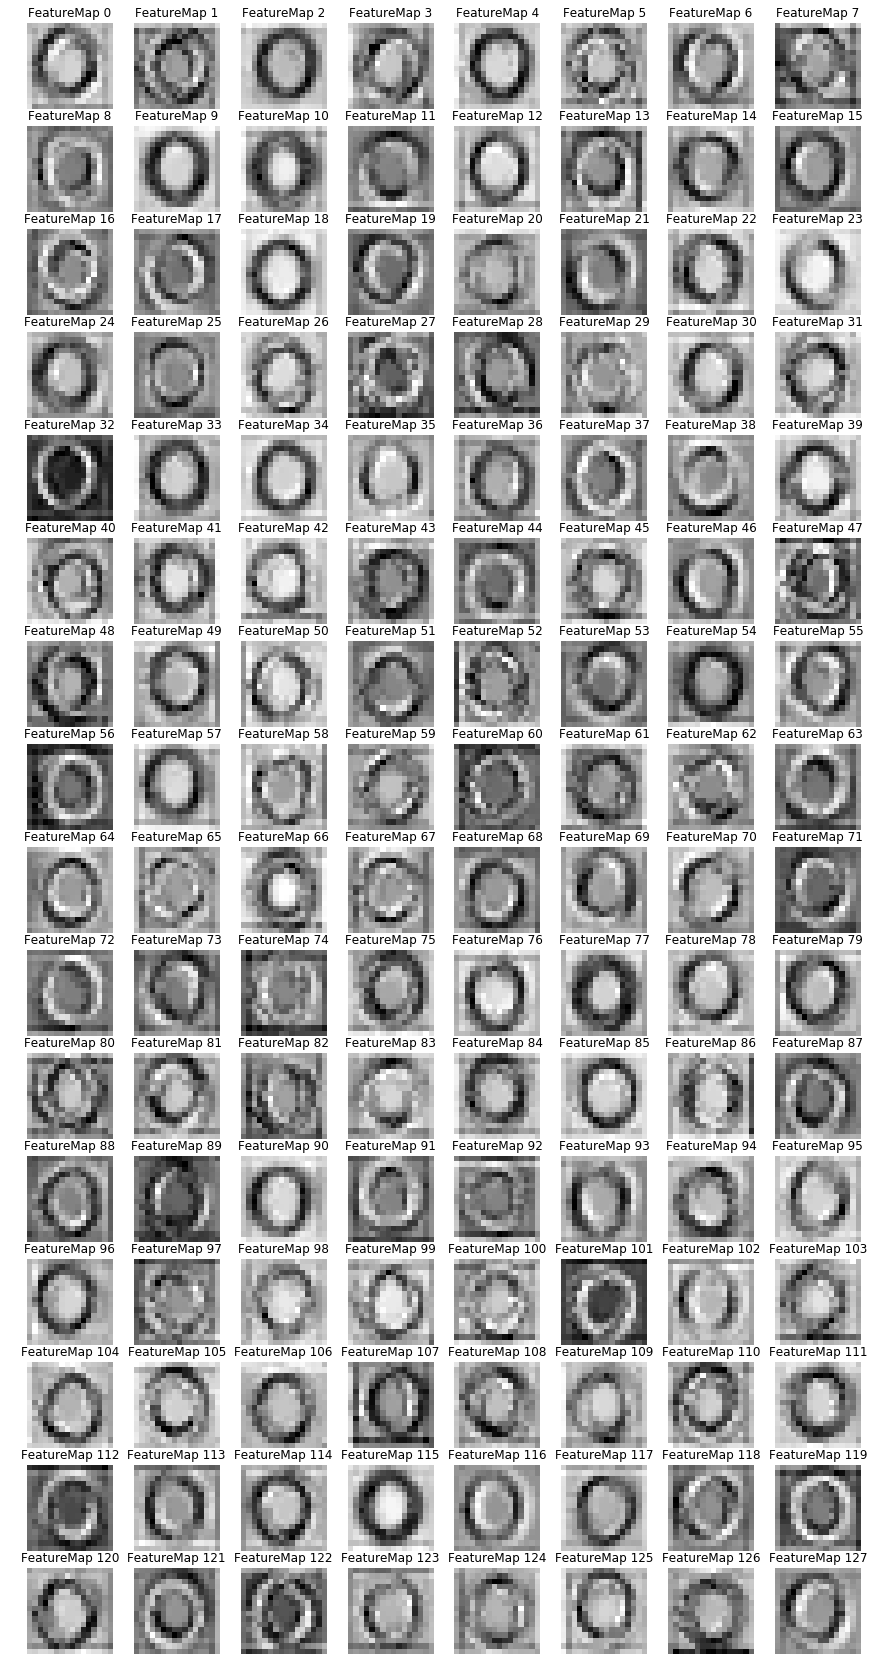

In [135]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    # load the default graph
    graph = tf.get_default_graph()
    
    # Visualizing the output of the first convolution of the second block
    conv2 = graph.get_tensor_by_name('conv2d_1_0:0')
    
    for i in range(len(test_images)):
        print('Image: {}'.format(i + 1))
        outputFeatureMap(sess, np.expand_dims(test_images[i], 0), conv2)
        plt.savefig('visualization/im{}.png'.format(i + 1), bbox_inches='tight')
        plt.show()
